## Import packages

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import matplotlib.pyplot as plt
from IPython.display import Image

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/producers-direct-2/producersdirectdata.parquet


## Import dataset

In [2]:
# The following code will only execute
# successfully when compression is complete

# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "producersdirectdata.parquet"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "ariellien/producers-direct-2",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

print("First 5 records:", df.head())

/tmp/ipykernel_39/2146353332.py:13: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


First 5 records:    question_id  question_user_id question_language  \
0      3849056            519124               nyn   
1      3849061            521327               eng   
2      3849077            307821               nyn   
3      3849077            307821               nyn   
4      3849077            307821               nyn   

                                    question_content question_topic  \
0       E ABA WEFARM OFFICES ZABO NIZISHANGWA NKAHI?           None   
1  Q this goes to wefarm. is it possible to get f...           None   
2  E ENTE YANJE EZAIRE ENYENA YASHOBERA. \nOBWIRE...         cattle   
3  E ENTE YANJE EZAIRE ENYENA YASHOBERA. \nOBWIRE...         cattle   
4  E ENTE YANJE EZAIRE ENYENA YASHOBERA. \nOBWIRE...            cat   

            question_sent  response_id  response_user_id response_language  \
0  2017-11-22 12:25:03+00     20691011            200868               nyn   
1  2017-11-22 12:25:05+00      4334249            526113               eng 

## General vs. Specific Question Proportions (English only)

I'm currently analyzing the English subset of the data, which contains approximately 11.5 million English question-and-answer pairs. Preliminary results show a clear imbalance, with 66% being Specific Questions and roughly 34% being General Questions. The final analysis will be updated once the translated data is fully converted to English and integrated.

In [3]:
# Combine both language conditions using the logical AND operator (&)
both_eng_mask = (df['response_language'].str.contains('eng', case=False, na=False)) & \
                (df['question_language'].str.contains('eng', case=False, na=False))

# Apply the combined mask to filter the DataFrame. Using .copy() to avoid SettingWithCopyWarning.
df1 = df[both_eng_mask].copy()

# Select the required columns for analysis
CHALLENGE_4_COLUMNS = [
    'question_id',
    'question_topic',
    'question_content',
    'response_content',
    'question_sent',
    'question_user_country_code',
    'question_language',
    'response_language',
]
df1 = df1[CHALLENGE_4_COLUMNS]

# --- B. Data Cleaning and Classification ---

# 1. NaN Handling
# Fill NaN values in the 'question_topic' column with 'General_Topic'
df1['question_topic'].fillna('General_Topic', inplace=True)


# 2. Text Cleaning (Creating 'question_content_cleaned')
def clean_text(text):
    if pd.isna(text):
        return ''
    text = str(text).lower().strip()
    text = re.sub(r'^[qes][\s\.\-]*', '', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Create the cleaned content column
df1['question_content_cleaned'] = df1['question_content'].apply(clean_text)


# 3. Binary Topic Classification
# List of topics considered 'General' or non-specific
GENERAL_TOPICS_LIST = [
    'General_Topic', 'crop', 'plant', 'animal', 'tree', 'livestock',
    'vegetable', 'bird', 'grass', 'market', 'dog', 'cat', 'poultry'
]

# Create the broad_topic column: Correctly use df1['question_topic'] for the operation
df1['broad_topic'] = df1['question_topic'].apply(
    lambda x: 'General' if x in GENERAL_TOPICS_LIST else 'Specific (Crop/Livestock)'
)


# --- C. Visualization (Overall Proportion Pie Chart) ---

# Calculate the overall proportions
broad_topic_counts = df1['broad_topic'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 8))

# Define colors and labels
labels = broad_topic_counts.index
sizes = broad_topic_counts.values
colors = ['#4CAF50', '#FFC107'] # Green for Specific, Yellow/Orange for General

# Plot the pie chart
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'edgecolor': 'black'}
)

plt.title('Relative Proportion of Specific vs. General Questions (Overall)', fontsize=14)
plt.axis('equal')
plt.tight_layout()

PLOT_PROPORTION = 'topic_proportion_overall.png'
plt.savefig(PLOT_PROPORTION)
plt.close()


# --- D. Time Variable Processing and Trend Visualization (Line Chart) ---

# 1. Convert to datetime and extract Year-Month
df1['question_sent'] = pd.to_datetime(df1['question_sent'], format='mixed', errors='coerce')
df1['Year_Month'] = df1['question_sent'].dt.to_period('M').astype(str)

# 2. Group by Month and Broad Topic, then calculate proportions
trend_counts = df1.groupby(['Year_Month', 'broad_topic']).size().unstack(fill_value=0)
trend_counts['Total'] = trend_counts.sum(axis=1)
trend_proportions = trend_counts.div(trend_counts['Total'], axis=0) * 100

df_trend_plot = trend_proportions[['General', 'Specific (Crop/Livestock)']].copy()

# 3. Visualization (Line Chart)
plt.figure(figsize=(12, 6))

plt.plot(df_trend_plot.index, df_trend_plot['General'], label='General Questions (%)', marker='o', linestyle='-', linewidth=2, color='orange')
plt.plot(df_trend_plot.index, df_trend_plot['Specific (Crop/Livestock)'], label='Specific Questions (%)', marker='x', linestyle='--', linewidth=2, color='green')

plt.title('Monthly Trend: General vs. Specific Question Proportions', fontsize=14)
plt.xlabel('Time (Year-Month)', fontsize=12)
plt.ylabel('Proportion of Total Monthly Questions (%)', fontsize=12)
plt.ylim(0, 100)
plt.legend(loc='upper right')

plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

PLOT_TREND = 'topic_proportion_trend.png'
plt.savefig(PLOT_TREND)
plt.close()

print(f"Analysis complete. Two visualizations saved: {PLOT_PROPORTION} and {PLOT_TREND}")

/tmp/ipykernel_39/286184839.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df1['question_topic'].fillna('General_Topic', inplace=True)
/tmp/ipykernel_39/286184839.py:90: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df1['Year_Month'] = df1['question_sent'].dt.to_period('M').astype(str)


Analysis complete. Two visualizations saved: topic_proportion_overall.png and topic_proportion_trend.png


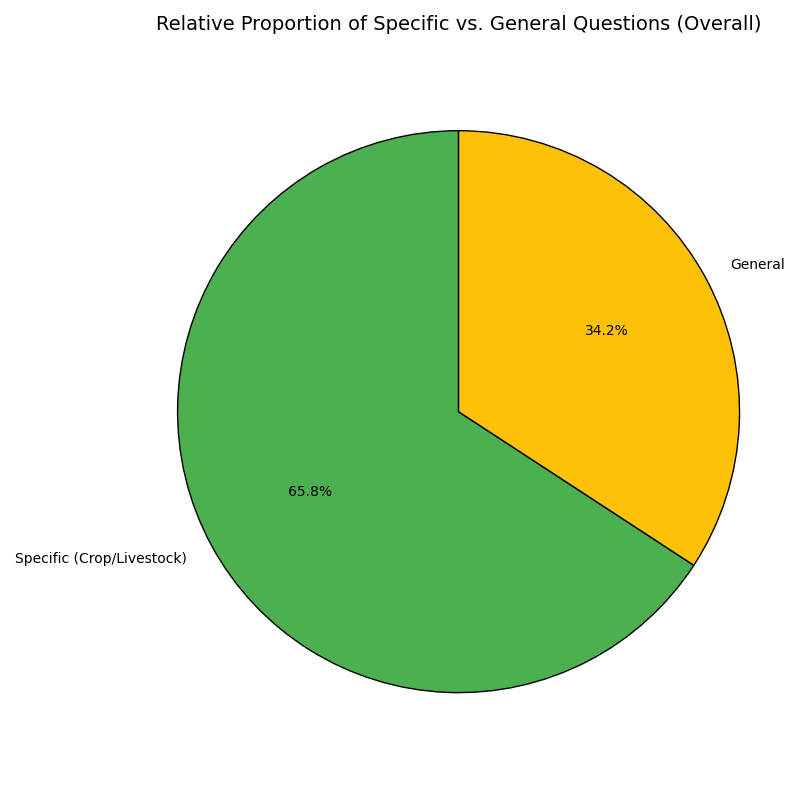

In [22]:
Image(filename='topic_proportion_overall.png')

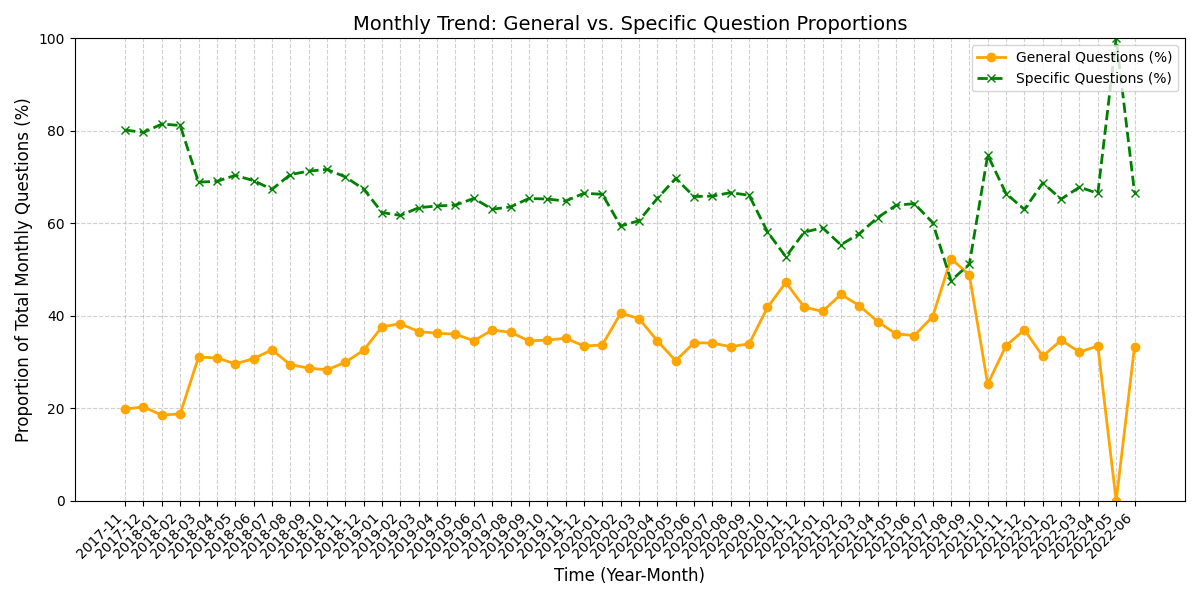

In [21]:
Image(filename='topic_proportion_trend.png')

The line chart shows that while Specific Questions generally dominate, I observed a distinct convergence between August 2021 and September 2021. During this period, the proportion of General and Specific questions became significantly closer. Drilling down into the raw data for this specific two-month window is needed to understand the cause of this major shift in farmer focus.

## Exploring Categories of General Questions

1. Keyword Dictionary (SUB_TOPIC_KEYWORDS)
This dictionary defines the complete set of general sub-topics. It is structured based on a strict priority order of farmer needs, moving from high-risk issues down to general knowledge:

Priority 1 (Risk/Finance): Captures immediate threats and financial needs (Pest & Disease, Market & Finance, Weather & Climate). These are checked first to ensure accuracy.

Priority 2 (Management/Technique): Captures Farming Technique (actions like 'how to', 'planting') and Soil & Water Management (foundational resource questions).

Priority 3 (Conceptual/Vague): Captures pure Concept & Definition (e.g., 'what is'), which serves as the final technical check, and Administrative/Vague (platform junk).

2. clean_content_for_topic Function
This function preprocesses the raw question text (question_content):

Standardization: Converts all text to lowercase.

Normalization: Replaces punctuation and special characters with spaces, then collapses multiple spaces into a single space.

Output: Ensures a consistent format (e.g., ' soil erosion ') for reliable keyword matching.

3. classify_sub_topic_priority Function
This is the core logic function:

It iterates through the SUB_TOPIC_KEYWORDS dictionary in the exact defined order.

It checks if any keyword in a topic is present in the cleaned question text using the robust space-padded matching (if f' {keyword} ' in content_cleaned:).

Priority Enforcement: The first match found determines the final sub_topic and the function immediately exits (returns), guaranteeing that a high-priority topic (like 'Pest') overrides a low-priority topic (like 'Technique').

4. Output and Visualization
Grouping: The code groups the data by the new sub_topic column and uses .size() to count the frequency of each question instance.

Normalization: Converts the counts into final percentages (topic_proportions).

Visualization: Generates a Bar Chart to visually display the percentage distribution, allowing quick identification of the most pressing General Topic. The chart title and labels are finalized to clearly communicate the results of the classification.

This **visualization** displays the top priorities of farmers when asking general, non-crop-specific questions, categorized using a priority-based keyword matching system.

The analysis reveals that the primary challenge for the farmers is a fundamental knowledge gap concerning general agricultural concepts and operational steps.

Key Findings and Interpretation:
Fundamental Knowledge Acquisition (Highest Need):

Farming Technique (28.66%) and Concept & Definition (15.48%) combine to form the largest area of farmer interest at 44.14%. Farmers are highly focused on actionable processes ("How to plant," "How to raise/grow") and acquiring basic definitions ("What is X").

Unclassified Portion (Noise/Unknown):

Unclassified_Other_Vague (34.79%): This remains the largest single category, representing noise, platform chatter, extreme misspellings, or unique localized questions that require human or semantic model intervention.

Top Risk & Resource Themes:

Soil & Water Management (6.93%): Questions focusing on land health, fertility, and irrigation practices.

Weather & Climate (5.29%): The most pressing environmental risk topic, concerned with drought, rain, and season timing.

Pest & Disease (4.27%): Questions about general health and treatment.

Market & Finance (3.87%): Lower priority, indicating that while farmers need technical guidance, commercial inquiries are less frequent in this general question set.

In [4]:
general_index = df1['broad_topic'] == 'General'
df_general = df1[general_index]

In [26]:
# --- Define Final Sub-Topics Keywords---
SUB_TOPIC_KEYWORDS = {
# 1. IMMEDIATE ACTION/RISK (Highest Priority - MUST NOT BE OVERRIDDEN)
    'Pest & Disease': ['pest', 'disease', 'spray', 'chemical', 'deworm', 'vaccinate', 'coccidiosis', 'mastitis', 
                       'armyworm', 'army worm', 'armyworms', 'fall armyworm', 'fungus', 'sick', 'treatment'],
    
    
    'Market & Finance': ['market', 'price', 'cost', 'loan', 'credit', 'sell', 'buy', 'money', 'business', 'start project'],
    'Weather & Climate': ['weather', 'rain', 'drought', 'climate', 'flood', 'season', 'wet', 'dry', 'hot', 'cold'], 
    
    # 2. FOUNDATIONAL MANAGEMENT (High Priority)
    'Soil & Water Management': ['soil', 'erosion', 'ph', 'fertilizer', 'irrigation', 'water', 'mulching', 'terrace', 'moisture', 'manure', 'compost'],
    
    # 3. FARMING TECHNIQUE (General Actions - Lower Priority)
    'Farming Technique': ['farming', 'agriculture', 'pruning', 'weeding', 'cultivation', 'planting', 'cultivate', 'prune', 'weed', 'seed', 'harrowing', 'ploughing', 'poultly', 'poultry', 'keping', 'plant', 'raise', 'grow'], # Added 'raise' and 'grow'
    
    # 4. CONCEPTUAL (Pure Definitions - Must be checked AFTER Action/Technique)
    'Concept & Definition': ['what is', 'what means', 'meaning of', 'define', 'explain', 'what are', 'is it', 
                             'wat is', 'what type', 'what causes', 'what do', 'which plant', 'which crop'], # Removed generic 'how to', 'how can'
    
    # 5. ADMINISTRATIVE/VAGUE (Lowest Priority/Junk)
    'Administrative/Vague': ['how are you', 'waka', 'join', 'send information', 'call', 'text', 'offices', 'member', 'whatsapp', 'thank u', 'simu', 'namba', 'job call', 'hello', 'irene', 'buy', 'sell']
}

# --- Define Helper Functions ---
def clean_content_for_topic(content):
    if pd.isna(content) or content is None:
        return ''
    content = str(content).lower()
    content = re.sub(r'[^a-z0-9\s]', ' ', content)
    content = re.sub(r'\s+', ' ', content)
    return f' {content.strip()} '

def classify_sub_topic_priority(content_cleaned, keywords_dict):
    if content_cleaned == ' ':
        return 'Unknown'
    
    # Logic relies on the dictionary being defined in priority order
    for topic, keywords in keywords_dict.items():
        for keyword in keywords:
            if f' {keyword} ' in content_cleaned:
                return topic
    
    return 'Unclassified_Other_Vague'


# --- 1. Apply Cleaning and Classification ---
# Re-create 'question_content_cleaned' (needed for classification)
df_general['question_content_cleaned'] = df_general['question_content'].apply(clean_content_for_topic)


# --- 2. Apply Classification to the Filtered Data ---
df_general['sub_topic'] = df_general['question_content_cleaned'].apply(
    lambda x: classify_sub_topic_priority(x, SUB_TOPIC_KEYWORDS)
)


# --- 3. Summarize Results (Using .size() for frequency/count) ---
topic_summary = df_general.groupby('sub_topic').size().sort_values(ascending=False)
total_questions = topic_summary.sum()
topic_proportions = (topic_summary / total_questions) * 100

print(f"Total General Question Instances Analyzed: {total_questions}")
print("--- FINAL CROSS-CUTTING TOPIC BREAKDOWN (Proportion) ---")
print(topic_proportions.to_string(float_format="%.2f%%"))


# --- 4. Visualization (Bar Chart) ---
plt.figure(figsize=(10, 6))
# Ensure the bar colors are set correctly for all topics (using a generic colormap/list)
bars = plt.bar(topic_proportions.index, topic_proportions.values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2'])

plt.title('Distribution of General Questions into Cross-Cutting Topics', fontsize=14)
plt.ylabel('Proportion of Total General Questions (%)', fontsize=12)
plt.xlabel('Sub-Topic', fontsize=12)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval:.1f}%', ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

PLOT_FILE = 'general_topic_breakdown_final_corrected.png'
plt.savefig(PLOT_FILE)
plt.close()

print(f"\nVisualization saved to {PLOT_FILE}")

/tmp/ipykernel_39/3269362328.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general['question_content_cleaned'] = df_general['question_content'].apply(clean_content_for_topic)
/tmp/ipykernel_39/3269362328.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_general['sub_topic'] = df_general['question_content_cleaned'].apply(


Total General Question Instances Analyzed: 3941895
--- FINAL CROSS-CUTTING TOPIC BREAKDOWN (Proportion) ---
sub_topic
Unclassified_Other_Vague   34.69%
Farming Technique          28.65%
Concept & Definition       15.46%
Soil & Water Management     6.93%
Weather & Climate           5.29%
Pest & Disease              4.40%
Market & Finance            3.87%
Administrative/Vague        0.72%

Visualization saved to general_topic_breakdown_final_corrected.png


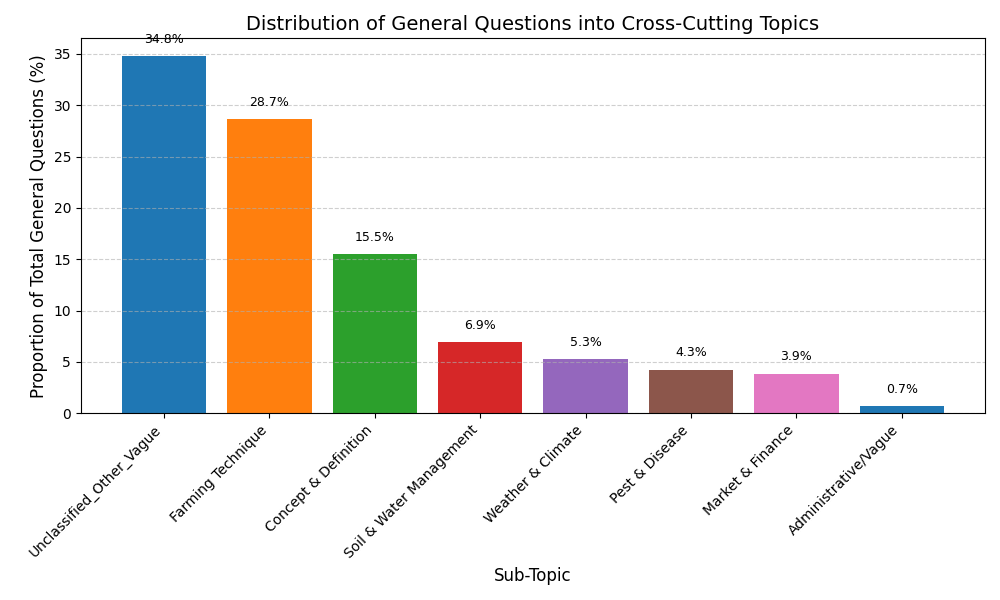

In [17]:
Image(filename='general_topic_breakdown_final_corrected.png')

In [23]:
# Set display options to show full content without truncation
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000) # Optional: Increase screen width display limit
print(df_general['sub_topic'].unique())
general_question_keywords = df_general[['question_content_cleaned','sub_topic']].['sub_topic'] == 'Unclassified_Other_Vague'
general_question_keywords.to_csv('general_question_keywords.csv', index = False)
df_general[['question_content_cleaned','sub_topic']].head(20)

SyntaxError: invalid syntax (3878391054.py, line 5)

In [25]:
army_worm_mask = df_general['question_content_cleaned'].str.contains('army worms', case=False, na=False)

# Example use: View all questions containing 'army worm'
army_worm_questions = df_general[army_worm_mask]
army_worm_questions

,question_id,question_topic,question_content,response_content,question_sent,question_user_country_code,question_language,response_language,question_content_cleaned,broad_topic,Year_Month,sub_topic
16587,3908416,crop,Q My garden of maize crop is infested with army worms. how do i control them? TUMUSIIME MWIJE,Q1 spray using pestcides.,2017-11-25 18:02:32+00:00,ug,eng,eng,q my garden of maize crop is infested with army worms how do i control them tumusiime mwije,General,2017-11,Unclassified_Other_Vague
16588,3908416,crop,Q My garden of maize crop is infested with army worms. how do i control them? TUMUSIIME MWIJE,Q17 try insectcides,2017-11-25 18:02:32+00:00,ug,eng,eng,q my garden of maize crop is infested with army worms how do i control them tumusiime mwije,General,2017-11,Unclassified_Other_Vague
16589,3908416,crop,Q My garden of maize crop is infested with army worms. how do i control them? TUMUSIIME MWIJE,Q16 use super gro with insecticides in order to enhance the work of an insecticide,2017-11-25 18:02:32+00:00,ug,eng,eng,q my garden of maize crop is infested with army worms how do i control them tumusiime mwije,General,2017-11,Unclassified_Other_Vague
16590,3908416,crop,Q My garden of maize crop is infested with army worms. how do i control them? TUMUSIIME MWIJE,A16 Through spraying by using tofugo,2017-11-25 18:02:32+00:00,ug,eng,eng,q my garden of maize crop is infested with army worms how do i control them tumusiime mwije,General,2017-11,Unclassified_Other_Vague
20271,3921631,General_Topic,Q what is murang'a county officials doing to abolish army worms,Q1 nothing,2017-11-27 06:26:57+00:00,ke,eng,eng,q what is murang a county officials doing to abolish army worms,General,2017-11,Concept & Definition
...,...,...,...,...,...,...,...,...,...,...,...,...
20193051,58861049,General_Topic,hw can army worms be controlled Reply Q,Q461. By Spraying The Army Worms.,2021-09-04 17:26:34.820853+00:00,ug,eng,eng,hw can army worms be controlled reply q,General,2021-09,Unclassified_Other_Vague
20193052,58861049,General_Topic,hw can army worms be controlled Reply Q,Can be controlled by spraying using pesticids.,2021-09-04 17:26:34.820853+00:00,ug,eng,eng,hw can army worms be controlled reply q,General,2021-09,Unclassified_Other_Vague
20256029,59054982,plant,"Q, what's the MAIN course of ARMY WORMS that usually atacks MAIZE PLANTS in a farm during early stage when growing?",Q93 Its at their lava stage,2021-09-24 18:46:06.192060+00:00,ke,eng,eng,q what s the main course of army worms that usually atacks maize plants in a farm during early stage when growing,General,2021-09,Unclassified_Other_Vague
20304320,59251750,General_Topic,Q what is the best pestcide for fall army worms.,Q1309 note,2022-04-04 15:34:53.725556+00:00,ke,eng,eng,q what is the best pestcide for fall army worms,General,2022-04,Concept & Definition


In [ ]:
#What topics cut across all crops(e.g., weather, pests, soil management) => General' questions and categorize them further into sub-topics, by season and location
#Are certain questions repeated? => hot topic 
#How do farmers respond to more general answers vs more specific answers? length of response or NA proportion
